Post-Processing

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import nibabel as nib
from scipy import ndimage

In [7]:
# Voxel Volume

import pydicom
mri_slice = pydicom.dcmread("D:/MRI - Tairawhiti (User POV)/Raw DICOM MRI Scans/7_AutoBindWATER_450_10B/IM-0118-0009.dcm")

pixel_spacing = mri_slice.PixelSpacing
slice_thickness = mri_slice.SliceThickness

voxel_volume = float(pixel_spacing[0]) * float(pixel_spacing[1]) * float(slice_thickness)
print('Pixel Space: ',pixel_spacing)
print('Slice Thickness: ', slice_thickness)
print('Volume of Single Voxel = ', voxel_volume)

Pixel Space:  [0.9375, 0.9375]
Slice Thickness:  3
Volume of Single Voxel =  2.63671875


: 

In [6]:
def post_process_segmentation(segmented_image, min_region_size_ratio=0.01):
    # Hole Filling
    # Find the complement of the segmented image (invert it)
    inverted_image = 1 - segmented_image
    
    # Label connected components in the inverted image
    labeled_components, num_components = ndimage.label(inverted_image)
    
    # Calculate the threshold for removing small holes based on the total segmentation area
    total_wound_pixels = np.sum(segmented_image)
    min_region_size = int(min_region_size_ratio * total_wound_pixels)
    
    # Remove small holes by setting them back to 1 (region of interest)
    for component in range(1, num_components + 1):
        component_size = np.sum(labeled_components == component)
        if component_size < min_region_size:
            segmented_image[labeled_components == component] = 1

    # Step 2: Remove small noise
    # Label connected components in the segmented image
    labeled_components, num_components = ndimage.label(segmented_image)
    
    # Calculate the threshold for removing small noise based on the total wound area
    min_noise_size = int(min_region_size_ratio * total_wound_pixels)
    
    # Remove small noise by setting them back to 0 (non-wound)
    for component in range(1, num_components + 1):
        component_size = np.sum(labeled_components == component)
        if component_size < min_noise_size:
            segmented_image[labeled_components == component] = 0

    return segmented_image


def superimpose_images(image1, image2):
    image1 = image1 / np.max(image1)
    image2 = image2 / np.max(image2)
    alpha = 0.5
    superimposed_image = alpha * image1 + (1 - alpha) * image2
    return superimposed_image

In [ ]:
import numpy as np
from scipy import ndimage

def denoising_algo(segmented_volume, min_region_size_ratio=0.01):
    depth, height, width = segmented_volume.shape
    
    post_processed_volume = np.zeros_like(segmented_volume)
    
    for z in range(depth):
        segmented_image = segmented_volume[z, :, :]
        
        # Hole Filling
        inverted_image = 1 - segmented_image
        labeled_components, num_components = ndimage.label(inverted_image)
        total_aoi_pixels = np.sum(segmented_image)
        min_region_size = int(min_region_size_ratio * total_aoi_pixels)
        
        for component in range(1, num_components + 1):
            component_size = np.sum(labeled_components == component)
            if component_size < min_region_size:
                segmented_image[labeled_components == component] = 1

        # Remove small noise using adaptive thresholding (small artifact removal)
        labeled_components, num_components = ndimage.label(segmented_image)
        min_noise_size = int(min_region_size_ratio * total_aoi_pixels)
        
        for component in range(1, num_components + 1):
            component_size = np.sum(labeled_components == component)
            if component_size < min_noise_size:
                segmented_image[labeled_components == component] = 0
        
        post_processed_volume[z, :, :] = segmented_image

    return post_processed_volume

In [7]:
fname = 'msk_021'
model = 'resnet(0.91 DSC, 3 Patients, 3 Epoches)'
base_dir = 'D:/MRI - Tairawhiti (User POV)'
slice = 80

scan = nib.load(('{}/nnUNet Data/scans/{}.nii.gz').format(base_dir, fname))
msk_pred = nib.load(('{}/Pre-Trained Models (Google Colab)/{}/{}.nii.gz').format(base_dir, model, fname))
msk_gt = nib.load(('{}/nnUNet Data/multiclass_masks/{}.nii.gz').format(base_dir, fname))

scan_data = scan.get_fdata()
msk_pred_data = msk_pred.get_fdata()
# msk_pred_data = np.expand_dims(msk_pred_data, axis = -1)
msk_gt_data = msk_gt.get_fdata()


plt.imshow(msk_pred_data[slice, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('pred mask')
plt.show()

plt.imshow(msk_gt_data[slice, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('gt mask')
plt.show()

print(msk_pred_data.shape)
print(msk_gt_data.shape)

ValueError: operands could not be broadcast together with shapes (501,512,512,1) (501,256,256,1) 

: 

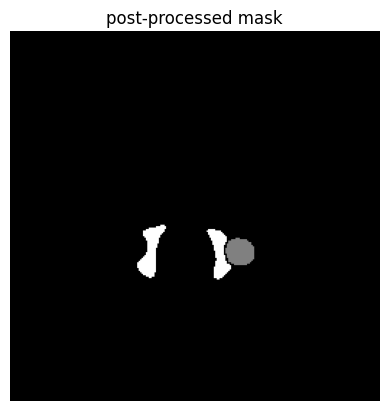

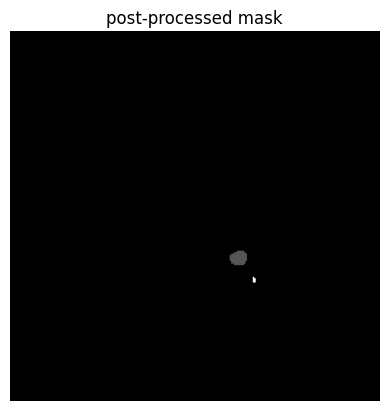

In [27]:
segmented_image = post_process_segmentation(msk_pred_data[80,:,:,0], min_region_size_ratio=0.01)

plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.title('post-processed mask')
plt.show()


segmented_image = post_process_segmentation(msk_pred_data[400,:,:,0], min_region_size_ratio=0.01)

plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.title('post-processed mask')
plt.show()

Cropping

Cropped Prediction Shape:  (833, 256, 176, 1)
Cropped Groundtruth Shape:  (833, 256, 176, 1)


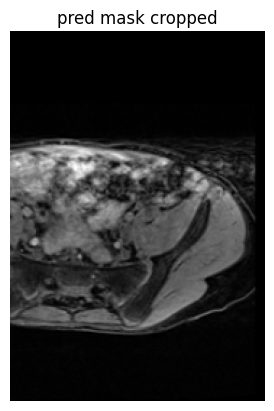

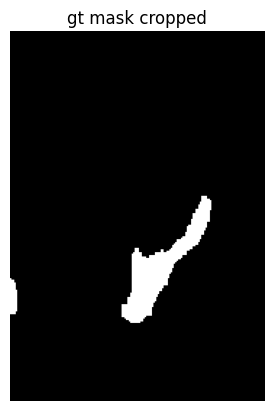

In [14]:
from preprocessing import superimpose_images
from image_preprocessing import image_cropping

slice = 50

msk_pred_data_cropped = image_cropping(msk_pred_data, top = 0, bottom = 0, left = 80, right = 0)
msk_gt_data_cropped = image_cropping(msk_gt_data, top = 0, bottom = 0, left = 80, right = 0)

print('Cropped Prediction Shape: ', msk_pred_data_cropped.shape)
print('Cropped Groundtruth Shape: ', msk_gt_data_cropped.shape)

plt.imshow(msk_pred_data_cropped[slice, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('pred mask cropped')
plt.show()

plt.imshow(msk_gt_data_cropped[slice, :, :, 0], cmap='gray')
plt.axis('off')
plt.title('gt mask cropped')
plt.show()


nii_img_pred = nib.Nifti1Image(msk_pred_data_cropped, affine=msk_pred.affine)
nii_img_gt = nib.Nifti1Image(msk_gt_data_cropped, affine=msk_gt.affine)

if False:
    nib.save(nii_img_pred, ('{}/Pre-Trained Models (Google Colab)/{}/{}_pred_postprocessed.nii.gz').format(base_dir, model, fname))
    nib.save(nii_img_gt, ('{}/Pre-Trained Models (Google Colab)/{}/{}_gt_postprocessed.nii.gz').format(base_dir, model, fname))